## Model Building in XGBoost

This is a great article for tunning XGboost: http://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [1]:
import os
windows=False
if (windows):
    mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
    os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import time
import csv
import boto # to download from AWS S3 buckets

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [3]:
#Let's define variables that will define the behaviour of the whole script
s3_path = 'http://bbts-kaggle.s3.amazonaws.com/bimbo/Pablo/'
use_validation=True # splits train data into train + val sets
val_week_threshold = 8 # (possible values 8 or 9)  - weeks 3,4,5,6,7 are train, and week 8.9 are val
trimmed = True # removes weeks which doesn't have all the lags. If False, fills empty lags with 0
lag = 5  # shifted mean_demand up to "lag" weeks
if (val_week_threshold == 8): lag = 4

In [4]:
#now we load our modified train and test set
tic()
sufix=""
if (use_validation): 
    sufix += "_holdout"
    sufix += repr(val_week_threshold)
if (trimmed): sufix += "_trimmed"

print ('Downloading File: train_modified{}.csv  ...'.format(sufix))
train = pd.read_csv("{}train_modified{}.csv".format(s3_path,sufix),
                    dtype = {'Canal_ID': 'int8',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                   )

if (use_validation):
    print ('Downloading File: val_modified{}.csv  ...'.format(sufix))
    val = pd.read_csv("{}val_modified{}.csv".format(s3_path,sufix),
                    dtype = {'Canal_ID': 'int8',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                   ) 

print ('Downloading File: test_modified{}.csv  ...'.format(sufix))
test = pd.read_csv("{}test_modified{}.csv".format(s3_path,sufix),
                    dtype = {'id': 'uint32',
                            'Canal_ID': 'int8',
                            'brand': 'int8',
                            'prodtype_cluster': 'int32',
                            'Qty_Ruta_SAK_Bin': 'int32',
                            'ZipCode': 'uint32',
                            'week_ct': 'int8',
                            'NombreCliente': 'int32',
                            'Producto_ID_clust_ID':'int32',
                            'Ruta_SAK_clust_ID':'int32',
                            'Agencia_ID_clust_ID':'int32',
                            'Cliente_ID_clust_ID':'int32'},
                      )
tac()

Time passed: 0hour:4min:10sec


In [5]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

In [17]:
#val.pop('predictions')
val.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,...,brand,prodtype_cluster,Qty_Ruta_SAK_Bin,ZipCode,week_ct,NombreCliente,Producto_ID_clust_ID,Ruta_SAK_clust_ID,Agencia_ID_clust_ID,Cliente_ID_clust_ID
0,8,1110,7,3301,15766,1216,1.791759,0.138243,0.128988,0.081382,...,1,2,1,2008,0,11,20,68,5,100
1,8,1110,7,3301,15766,1238,1.386294,0.138243,0.128988,0.128988,...,1,2,1,2008,0,11,20,68,5,100
2,9,1110,7,3301,15766,1238,1.098612,0.138243,0.000000,0.128988,...,1,2,1,2008,1,11,20,68,5,100
3,8,1110,7,3301,15766,1240,1.098612,0.230405,0.257975,0.000000,...,1,14,1,2008,0,11,24,68,5,100
4,9,1110,7,3301,15766,1240,1.098612,0.230405,0.000000,0.257975,...,1,14,1,2008,1,11,24,68,5,100


## Train multiple models per client cluster

Ok, so we said on our prior step (Models wiht scikit-learn) that we need to deal with the data set high variance. Let's do this first:

Looking at the plot below, created on the clustering-by-demand on the feature engineering notebook, we see that some client cluster's demand behave very differntly from others. So this explain why our model is failing on predicting accurately for all of them.
We are going then to create a wrapper function to create as many models as Client Clusters by demand are (Cliente_ID_clust_ID). Let's see if the scores are bettter individually, and if the concatenation of all 300 models yields a better overall RSMLE than our baseline 0.47.

In order to do this, we are going to create a wrapper function called clusters_fit , who is going to iterate over all cluster and call model_fit in all of them. At the end it concatenates de results.

![Image of Variables vs Hypothesis](./input-data/h2o-clustByDem_Cliente_ID_400.png)

In [7]:
import xgboost as xgb
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

def model_fit(alg, ctrain, cval, ctest, predictors, target, IDcol):
    
    #Fit the algorithm on the data
    watchlist = [(cval[predictors], cval[target])]
    alg.fit(ctrain[predictors], ctrain[target], eval_set=watchlist, eval_metric='rmse', early_stopping_rounds=20, verbose=False)


    #Predict training set:
    ctrain["predictions"] = alg.predict(ctrain[predictors])
    ctrain["predictions"] = np.maximum(ctrain["predictions"], 0)

    
    #Predict validation (holdout) set:
    cval["predictions"] = alg.predict(cval[predictors])
    cval["predictions"] = np.maximum(cval["predictions"], 0)# we make all negative numbers = 0 since there cannot be a negative demand

    
    #Predict on testing data: we need to revert it back to target by applying expm1
    ctest[target] = alg.predict(ctest[predictors])
    ctest[target] = np.maximum(ctest[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
    
    return ctrain[[target,"predictions"]], cval[[target,"predictions"]], ctest[[IDcol,target]]
    

In [15]:
import tqdm
import sys
def clusters_fit (alg, dtrain, dval, dtest, predictors, target, IDcol):
    
    train_predictions = pd.DataFrame(index=[target,"predictions"])
    val_predictions = pd.DataFrame(index=[target,"predictions"])
    test_predictions = pd.DataFrame(index=[IDcol,target])
    
    clusters_list = train.Cliente_ID_clust_ID.drop_duplicates().get_values()
    np.random.shuffle(clusters_list)
    
    lcluster = 0;
    
    for cluster in tqdm.tqdm(clusters_list):  #tqdm is a genius progress bar library to print out progress
        
        #we get the cluster train,val, test data

        ctrain = dtrain.loc[dtrain["Cliente_ID_clust_ID"] == cluster]
        cval   = dval.loc[dval["Cliente_ID_clust_ID"] == cluster]
        ctest  = dtest.loc[dtest["Cliente_ID_clust_ID"] == cluster]
        
        #sys.stdout.write('\rCluster: {:.0f}'.format(cluster))
        
        #we train the cluster
        ctrain, cval, ctest = model_fit(model, ctrain, cval, ctest, predictors, target, IDcol)
        
        #rsmle_train =  np.sqrt(metrics.mean_squared_error(ctrain[target], ctrain["predictions"]))
        #rsmle_val = np.sqrt(metrics.mean_squared_error(cval[target], cval["predictions"]))
            
        #concatenate each cluster result
        train_predictions = pd.concat([train_predictions,ctrain],ignore_index=True)
        val_predictions = pd.concat([val_predictions,cval],ignore_index=True)
        test_predictions = pd.concat([test_predictions,ctest],ignore_index=True)
        
        #train_predictions.dropna(axis=0, how='any',inplace=True)
        #val_predictions.dropna(axis=0, how='any',inplace=True)
        #test_predictions.dropna(axis=0, how='any',inplace=True)
          
        #acc_rsmle_train =  np.sqrt(metrics.mean_squared_error(train_predictions[target], train_predictions["predictions"]))
        #acc_rsmle_val = np.sqrt(metrics.mean_squared_error(val_predictions[target], val_predictions["predictions"]))
        #rows_pct = cval.shape[0]*100/dval.shape[0]

        #sys.stdout.write('\r')
        #sys.stdout.write('\tRMSLE T: {:.4f}\tRMSLE V: {:.4f}\tRowsPct: {:.4f}\tACC. RSMLE TRAIN: {:.4f}\tACC. RSMLE VAL: {:.4f}'.format(
        #       rsmle_train, rsmle_val ,rows_pct, acc_rsmle_train, acc_rsmle_val))
        #sys.stdout.flush()

        
    #For some reason this function is adding to NaN rows at the beggining, I don't know why, but we'll remove them
    train_predictions.dropna(axis=0, how='any',inplace=True)
    val_predictions.dropna(axis=0, how='any',inplace=True)
    test_predictions.dropna(axis=0, how='any',inplace=True)
    
    return train_predictions, val_predictions, test_predictions
    

In [9]:
def report_submit(dtrain, dval, dtest, filename):
    
    #Print model report:
    print ("\nModel Report")
    print ('RMSLE TRAIN: ', np.sqrt(metrics.mean_squared_error(dtrain[target], dtrain["predictions"])))
    print ('RMSLE VAL: ', np.sqrt(metrics.mean_squared_error(dval[target], dval["predictions"])))
    
    #Predict on testing data: we need to revert it back to target by applying expm1
    dtest[target] = np.expm1(dtest[target])
    dtest[target] = np.maximum(dtest[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
  
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('NUM NEGATIVES PREDICTED: ', dtest[target][dtest[target] < 0].count())
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    #Export submission file:
    submission = dtest.copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)
    

In [10]:
# In case there is no validation, we make val = train
if not (use_validation):
    val = train.copy()

### Alg6 - XGB - Train each client cluster separately

Let's try training each of the client clusters separately and see if we have good results

100%|██████████| 300/300 [09:31<00:00,  2.09s/it]



Model Report
RMSLE TRAIN:  0.435551895662
RMSLE VAL:  0.495183113214
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0
MEAN TARGET PREDICTED:  4.978147328874419
MAX TARGET PREDICTED:  1721.07685618
Time passed: 0hour:10min:8sec


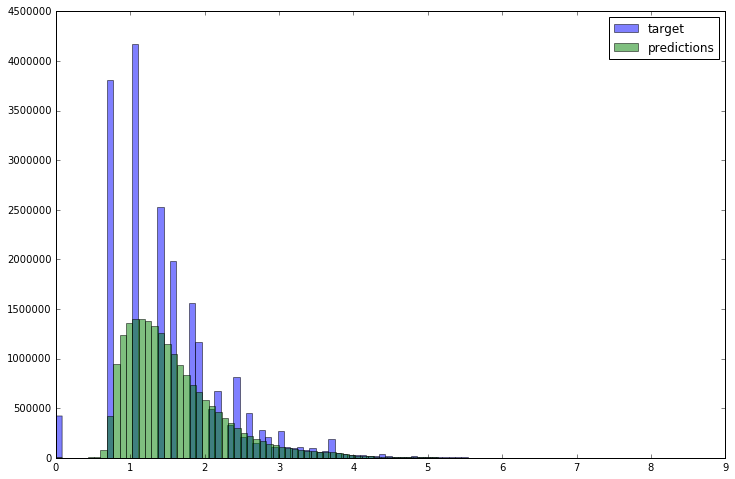

In [18]:
predictors = ['Producto_ID_clust_ID', 'Lags_sum', 'Producto_ID', 'prodtype_cluster', 'Canal_ID', 'Qty_Ruta_SAK_Bin', 'brand',
             'Ruta_SAK', 'ZipCode']              
for i in range(1,lag):
    predictors.insert(0,'Log_Target_mean_lag{}'.format(i))
 

model = xgb.XGBRegressor(n_estimators = 400, objective="reg:linear", learning_rate= 0.1, max_depth=5,
                         subsample=0.85,colsample_bytree=0.8, min_child_weight = 1, gamma = 0.1, scale_pos_weight = 1)

tic()
dt, dv, dte = clusters_fit(model, train, val, test, predictors, target, IDcol)
report_submit(dt, dv, dte, 'alg6_{}.csv'.format(sufix))
tac()

#Plot Histogram of target and prediction distributions
plt.hist(dv['log_target'], 100, alpha=0.5, label='target')
plt.hist(dv['predictions'], 100, alpha=0.5, label='predictions') 
plt.legend(loc='upper right')
plt.show()

### Alg7 - XGB - Train only one batch

And now let's compare it with training the complete training set

In [ ]:
predictors = ['Producto_ID_clust_ID', 'Lags_sum', 'Producto_ID', 'prodtype_cluster', 'Canal_ID', 'Qty_Ruta_SAK_Bin', 'brand',
             'Ruta_SAK', 'ZipCode']              
for i in range(1,lag):
    predictors.insert(0,'Log_Target_mean_lag{}'.format(i))
    
model = xgb.XGBRegressor(n_estimators = 500, objective="reg:linear", learning_rate= 0.1, max_depth=10,
                         subsample=0.85,colsample_bytree=0.7)

#model = xgb.XGBRegressor(n_estimators = 1, objective="reg:linear", learning_rate= 0.1, max_depth=5,
#                         subsample=0.85,colsample_bytree=0.8, min_child_weight = 1, gamma = 0.1, scale_pos_weight = 1)

tic()
dt, dv, dte = model_fit(model, train, val, test, predictors, target, IDcol)
report_submit(dt, dv, dte, 'alg7_{}.csv'.format(sufix))
tac()

feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

#Plot Histogram of target and prediction distributions
plt.hist(val['log_target'], 100, alpha=0.5, label='target')
plt.hist(val['predictions'], 100, alpha=0.5, label='predictions') 
plt.legend(loc='upper right')
plt.show()

#Plot Training and Validation scoring
plt.plot(model.evals_result()['validation_0']['rmse'])